In [2]:
import numpy as np
import pandas as pd
import xgboost as xb
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
data = load_boston()
X = data.data
y = data.target
columns = data.feature_names

In [4]:
trainX, testX, trainY, testY = train_test_split(X,y)
dTrainMatrix = xb.DMatrix(trainX, trainY)
dTextMatrix = xb.DMatrix(testX, testY)

# Run 1 - Baseline numbers without any model tuning

In [32]:
untunedParams = {"objective":"reg:linear","num_boost_round":"5","nfold":"3"}
cv_result = xb.cv(params=untunedParams, dtrain=dTrainMatrix, metrics='mae', as_pandas=True)
print (cv_result['test-mae-std'][4])

0.3404362544993636


# Run 2 - Basic Model Tuning
    - In this run we would try our algorithm with different number of boosting rounds and find an optimal value
    - After running the code we see that the RMSE starts getting flat around 20 boosting rounds
    - So by simply changing the boosting rounds we have been able to bring down the RMSE metric

In [33]:
boosting_rounds = [3,5,7,9,15,20,25,30]
untunedParams = {"objective":"reg:linear","nfold":"3"}
metric_values = []

for rounds in boosting_rounds:
    cv_result = xb.cv(params=untunedParams, dtrain=dTrainMatrix, metrics='mae', num_boost_round=rounds, as_pandas=True)
    metric_values.append(cv_result['test-mae-std'].tail().values[-1])
    
df = pd.DataFrame(data=list(zip(boosting_rounds, metric_values)), columns=['Boosting Rounds','MAE'])
print (df)

   Boosting Rounds       MAE
0                3  0.413893
1                5  0.340436
2                7  0.253658
3                9  0.186035
4               15  0.183521
5               20  0.199554
6               25  0.201904
7               30  0.203939


# Run 3 - Hyper Parameter tuning with GridSearchCV
    
    - GridSearchCV is like a brute force attack where all possible combinations of hyper parameters are evaluared.
    - Logic wise it works as follows:
        - Create a dictionary of fixed params; those params which would not change during the tuning exercise
        - Create a dictionary of variable params; those params which we want to evaluate
        - Create GridSearchCV() and pass in the following:
            - XGBClassifier or XGBRegressor ; in this we pass the fixed params
            - variable params
            - cv or cross validation count
            - scoring (scoring approach depends on Regression or Classification problem)
            
     - On this datasetp trying to tune the hyper parameters does not reduce MAE any further, instead it's increased !!!
     - Useful link
         - See https://scikit-learn.org/stable/modules/model_evaluation.html for scoring options

In [8]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold

In [35]:
fixed_params = {"objective":"reg:linear"}
variable_params = {
    "max_depth":np.arange(1,20,5),
    #"learning_rate":np.arange(0.1,0.4,0.1),
    "n_estimators":np.arange(5,50,10),
    #"alpha":np.arange(0.1,0.5,0.1),
    "num_boost_round":np.arange(10,40,10),
    "n_fold":np.arange(2,10,1)
}

gs_cv = GridSearchCV(XGBRegressor(**fixed_params), variable_params, cv=3, scoring='neg_mean_absolute_error')
gs_cv.fit(X,y)

print ('Best parameters are ', gs_cv.best_params_)
print ('Best score is ', np.abs(gs_cv.best_score_))

Best parameters are  {'max_depth': 11, 'n_estimators': 45, 'n_fold': 2, 'num_boost_round': 10}
Best score is  3.463954346170538


C:\MachineLearning\anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [38]:
print ('Evaluated params grid is \n', gs_cv.param_grid)
print ('\n\nBest model definition is \n', gs_cv.best_estimator_)

Evaluated params grid is 
 {'max_depth': array([ 1,  6, 11, 16]), 'n_estimators': array([ 5, 15, 25, 35, 45]), 'num_boost_round': array([10, 20, 30]), 'n_fold': array([2, 3, 4, 5, 6, 7, 8, 9])}


Best model definition is 
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=45, n_fold=2,
       n_jobs=1, nthread=None, num_boost_round=10, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)


# Run 3 - Hyper Parameter tuning with RandomSearchCV

    - RandomSearchCV extends the functionality of GridSearchCV
    - Just like in GridSearchCV we define the hyperparameters we want to tune, however unlike GridSearchCV, in RandomSearchCV we specify the number of iterations we want to evaluate - say n.
    - So out of total parameter combinations 'n' combinations would be randomly drawn and the model would be evaluated on that.

# Run 4 - Impact of Number of Threads and Model Training Time

    - Here we will find relationship b/w the time it takes to train the model and the number of threads used for tree creation
    - From results we see that while running with 3 threads we get good result on this data set

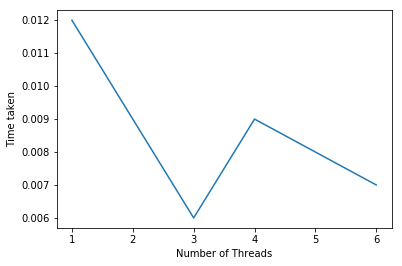

In [37]:
from time import time

#Specify number of threads as many cores you have on your machine
num_threads = [1,2,3,4,5,6]

time_taken = []
for thread in num_threads:
    start = time()
    xgb_reg = xb.XGBRegressor(max_depth=11, learning_rate=0.2, subsample=0.5, objective='reg:linear', n_estimators=10, reg_alpha=0.7, nthread=thread)
    model = xgb_reg.fit(X,y)
    end=time()
    time_taken.append(end-start)
    
plt.plot(num_threads, time_taken)
plt.xlabel('Number of Threads')
plt.ylabel('Time taken')
plt.show()